# Example using the Stepwise and Lasso linear regression functions

The stepAIC module includes two functions, **stepwise** and **lasso**, to find the set of predictor variables that optimizes either the Akaike Information Criterion (AIC, default) or Bayesian Information Criterion (BIC, optional) in a linear regression model.

### Stepwise

The **stepwise** function in the stepAIC module has the option to use either forward selection (default), backward selection, or all subsets of possible combinations for the optimum set of predictor variables as follows:

- Forward selection (default) starts with no predictors and adds predictors as long as it improves the model (reduces AIC or BIC, or increases adjusted rsquared)
- Backward selection starts with all predictors and removes predictors as long as it improves the model (reduces AIC or BIC, or increases adjusted rsquared)
- All subsets of possible combinations of predictor features to find the best of all possible models (up to 20 candidate predictors)

Either the AIC, BIC, or adjusted rsquared may be used as the criterion with forward, backward, or all subsets. In addition, there is an option to find all features with p-values less than a signficance threshold through backward elimination based only on the p-values of the coefficients. The stepwise algorithm also has the option (default) to remove any non-signficant predictors after either a forward, backward, or all subsets search using the AIC, BIC, or adjusted rsquared criterion. 

### Lasso

The lasso function in the stepAIC module provides output of regression models and summary statistics using the following methods:

- LassoCV: Lasso using Cross-Validation with coordinate descent to optimize alpha
- LassoLarsCV: Lasso using Cross-Validation with Least Angle Regression
- LassoLarsIC using AIC: Lasso using Least Angle Regression with Akaike Information Criterion
- LassoLarsIC using BIC: Lasso using Least Angle Regression with Bayesian Information Criterion

Lasso (Least Absolute Shrinkage and Selection Operator) adds a penalty to the loss function. This penalty encourages sparsity in the model, meaning that some coefficients will be exactly zero, effectively removing the corresponding predictors from the model.

Lasso linear regression includes a penalty term to the standard least squares objective function. The penalty term is a sum of the absolute values of the regression coefficients multiplied by a hyperparameter, denoted as "alpha". The lasso function finds the optimum value of alpha for each of the methods listed above. The alpha determines the amount of shrinkage applied to the model coefficients. As alpha increases, the coefficients are pushed towards zero, and some may become exactly zero, effectively eliminating those features from the model.

Lasso regression is useful for dealing with multicollinearity, where predictors are highly correlated, and when an optimal subset of the candidate features should be included in the model.

### AIC vs BIC

Using AIC as the criterion is the default in the stepAIC fuction. The user also has the option to use the BIC as the criterion instead. AIC is considered to be a useful critierion in stepwise regression. However, BIC is generally considered to be better than AIC for several reasons:

- Penalty for Complexity: BIC penalizes models more heavily for the number of parameters, making it more conservative and less likely to overfit, especially with larger sample sizes.
- Model Selection: BIC is particularly useful when the sample size is large, as it encourages simpler models that are less likely to capture noise.
- Model Recovery: Studies suggest that BIC tends to recover the true model more effectively than AIC, particularly in scenarios where the sample size is large.
While both criteria are useful for model selection, BIC is often preferred for its stricter criteria, which helps in avoiding overfitting and improving model interpretability

### Example data set

This example uses the diabetes data set described in the following tutorial by sklearn:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py


## Analysis of diabetes data using Lasso regression

Fitting Lasso regression models, please wait ...


Lasso regression statistics of best models in model_outputs['stats']:


| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     1.11865     |     1.10767     |     0.950407    |     0.950407    |
| r-squared          |     0.512957    |     0.512989    |     0.51341     |     0.51341     |
| adjusted r-squared |     0.503959    |     0.503991    |     0.50442     |     0.50442     |
| nobs               |   442           |   442           |   442           |   442           |
| df residuals       |   434           |   434           |   434           |   434           |
| df model           |     7           |     7           |     7           |     7           |
| F-statistic        |    65.2989      |    65.3073      |    65.4173      |    65.4173      |
| Prob (F-statistic) |

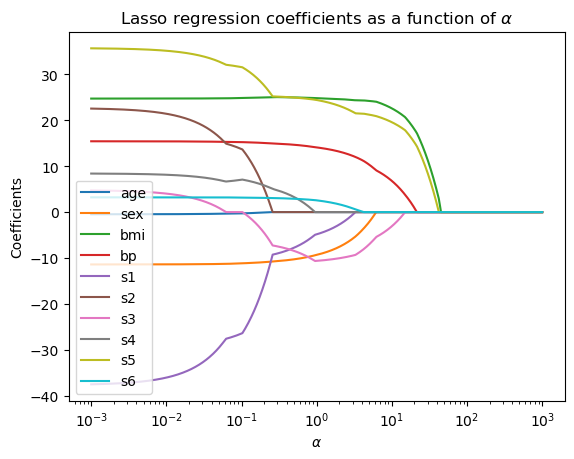

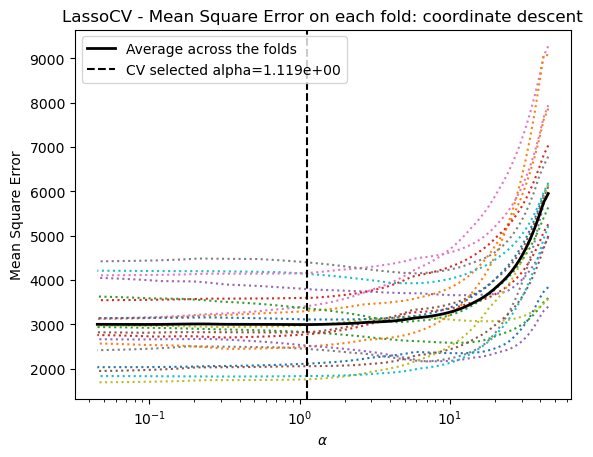

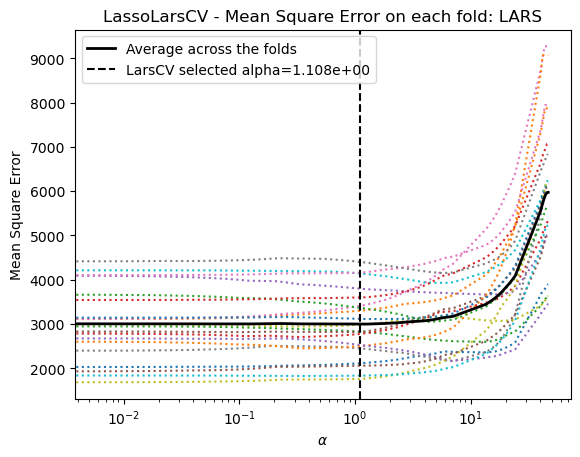

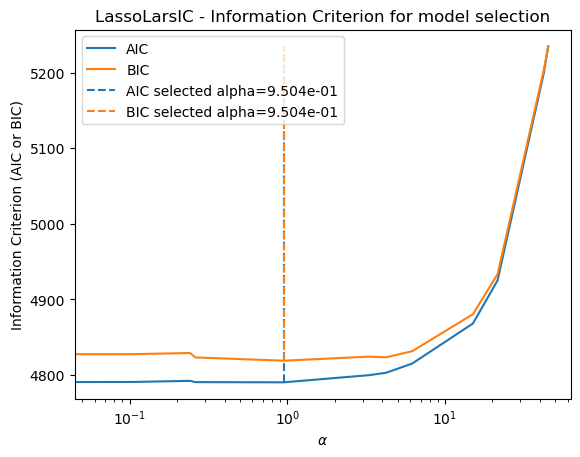

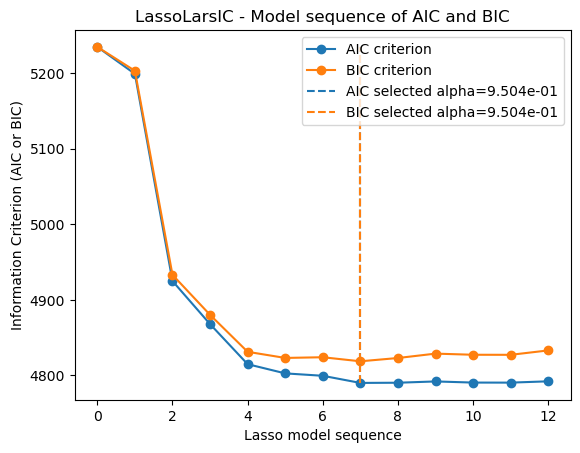

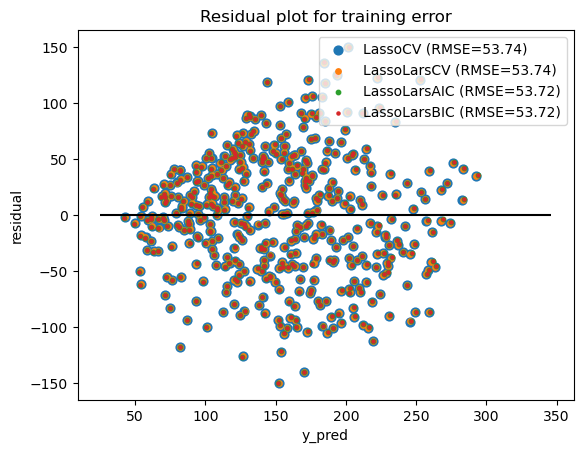

In [2]:
# Read X and y from the sklearn diabetes data set
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

# Use the lasso function in the stepAIC module
from stepAIC import lasso
model_objects, model_outputs = lasso(X, y)

The preceeding analysis using Lasso regression showed that the LassoLarsIC method using AIC or BIC as the criterion resulted in the same results. The LassoLarsIC (AIC and BIC) method resulted in slightly better performance compared with LassoCV and LassoLarsCV in terms of the Information Criterion. The VIF results of the Lasso models show that the selected features do not have excessive collinearity.

## Analysis using Stepwise regression with AIC as the criterion

In the next section we will use Stepwise regression with the following options:

- criterion='aic': This option will use AIC as the criterion
- direction='all': This option will analyze all of the possible subsets of features to find the best of all possible models
- standardize='on': This option will standardize the X dataframe of features using the sklearn.preprocessing StandardScaler in the same way as the preceeding analysis (standardizing features is the default setting in the lasso function).

Fitting models for all 1024 subsets of features, this may take up to a minute, please wait ...


Best 10 subsets of features in model_outputs['step_features']:

|   Rank |     AIC |     BIC |   rsq_adj | Features                                    |
|-------:|--------:|--------:|----------:|:--------------------------------------------|
|      0 | 4788.6  | 4817.24 |  0.508193 | ['sex' 'bmi' 'bp' 's1' 's2' 's5']           |
|      1 | 4788.6  | 4817.24 |  0.508193 | ['sex' 'bmi' 'bp' 's1' 's2' 's5']           |
|      2 | 4789.32 | 4822.05 |  0.508488 | ['sex' 'bmi' 'bp' 's1' 's2' 's4' 's5']      |
|      3 | 4789.37 | 4822.1  |  0.508429 | ['sex' 'bmi' 'bp' 's1' 's2' 's5' 's6']      |
|      4 | 4789.92 | 4818.56 |  0.506728 | ['sex' 'bmi' 'bp' 's1' 's4' 's5']           |
|      5 | 4790.12 | 4818.76 |  0.5065   | ['sex' 'bmi' 'bp' 's1' 's3' 's5']           |
|      6 | 4790.24 | 4827.06 |  0.508555 | ['sex' 'bmi' 'bp' 's1' 's2' 's4' 's5' 's6'] |
|      7 | 4790.47 | 4823.2  |  0.5072

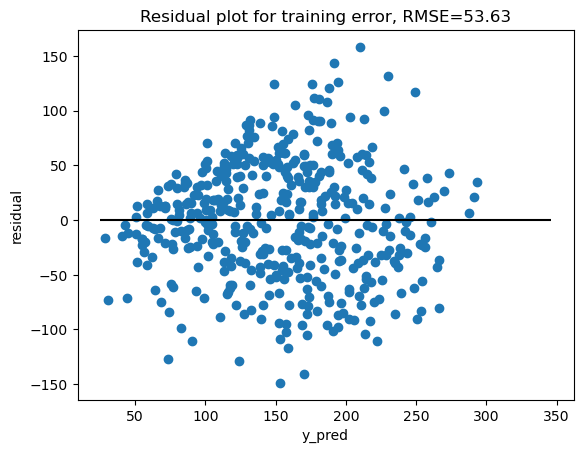

In [3]:
# Read X and y from the sklearn diabetes data set
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

# Use the stepwise function in the stepAIC module
from stepAIC import stepwise
best_model, best_features = stepwise(X, y, 
    criterion='aic', direction='all', standardize='on')

The results of the stepwise regression using AIC as the criterion resulted in a more parsomonious model with similar skill but fewer features compared with the results of Lasso regression (6 features in the final model using Stepwise regression with all subsets comapred with 7 features using Lasso regression). One possible concern about the results of using stepwise with AIC as the criterion is that the VIF values for 2 of the coefficients (s1 and s2) are greater than 5, which suggests possibly excessive collinearity. 

Next we will use Stepwise regression using BIC as the criterion to see if we can find a better model.

## Analysis using Stepwise regression with BIC as the criterion

The preceeding analysis using Lasso regression showed that the LassoLarsIC method using AIC or BIC as the criterion resulted in the same results with slightly better model skill compared with LassoCV and LassoLarsCV.

In the next section we will use Stepwise regression with the following options:

- criterion='bic': This option will use BIC as the criterion
- direction='all': This option will analyze all of the possible subsets of features to find the best model
- standardize='on': This option will standardize the X dataframe of features using the sklearn.preprocessing StandardScaler in the same way as the preceeding analysis.

Fitting models for all 1024 subsets of features, this may take up to a minute, please wait ...


Best 10 subsets of features in model_outputs['step_features']:

|   Rank |     AIC |     BIC |   rsq_adj | Features                               |
|-------:|--------:|--------:|----------:|:---------------------------------------|
|      0 | 4792.26 | 4816.81 |  0.502997 | ['sex' 'bmi' 'bp' 's3' 's5']           |
|      1 | 4792.26 | 4816.81 |  0.502997 | ['sex' 'bmi' 'bp' 's3' 's5']           |
|      2 | 4788.6  | 4817.24 |  0.508193 | ['sex' 'bmi' 'bp' 's1' 's2' 's5']      |
|      3 | 4789.92 | 4818.56 |  0.506728 | ['sex' 'bmi' 'bp' 's1' 's4' 's5']      |
|      4 | 4790.12 | 4818.76 |  0.5065   | ['sex' 'bmi' 'bp' 's1' 's3' 's5']      |
|      5 | 4791.09 | 4819.73 |  0.505419 | ['sex' 'bmi' 'bp' 's2' 's3' 's5']      |
|      6 | 4793.18 | 4821.82 |  0.503078 | ['sex' 'bmi' 'bp' 's3' 's4' 's5']      |
|      7 | 4789.32 | 4822.05 |  0.508488 | ['sex' 'bmi' 'bp' 's1' 's2' 's4' 's5'] |

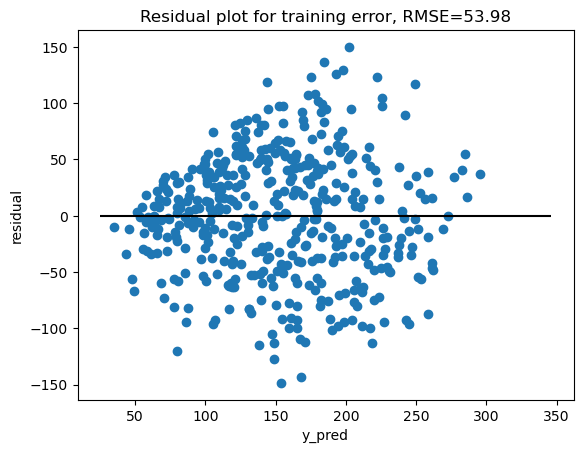

In [4]:
# Read X and y from the sklearn diabetes data set
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

# Use the stepwise function in the stepAIC package
from stepAIC import stepwise
best_model, best_features = stepwise(X, y, 
    criterion='bic', direction='all', standardize='on')

This analysis shows that using Stepwise regression, with the option to find the best of all subsets of features, and using BIC as the criterion, results in the most parsimonious model with similar skill compared with Stepwise using AIC, and also compared with using Lasso regression. Using Stepwise with BIC as the criterion results in 5 features in the final model with practically the same model skill. The VIF results of the Stepwise model using BIC as the criterion show that the selected features have the least collinearity of all of the preceeding methods, and do not have excessive collinearity.

## Conclusion

In conclusion, in this analysis it appears that using Stepwise regression outperforms Lasso regression if the objective is the find the most parsimonious model that optimizes the model skill and minimizes collinearity of the features. The option to analyze all subsets of features also assures that the best possible combination of features will be found. The option to use BIC as the criterion appears to find a more parsimonious model compared with using AIC as the criterion.